# A Cautionary Tutorial

This notebook is written by Dr. Robyn Speer (as we discussed in class). You should absolutely check out her work on using ConceptNet for Embeddings. Also, you can see the original notebook here:  http://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/  

## Let's make a sentiment classifier!

Sentiment analysis is a very frequently-implemented task in NLP, and it's no surprise. Recognizing whether people are expressing positive or negative opinions about things has obvious business applications. It's used in social media monitoring, customer feedback, and even automatic stock trading (leading to bots that [buy Berkshire Hathaway when Anne Hathaway gets a good movie review](https://www.theatlantic.com/technology/archive/2011/03/does-anne-hathaway-news-drive-berkshire-hathaways-stock/72661/)).

It's simplistic, sometimes too simplistic, but it's one of the easiest ways to get measurable results from NLP. In a few steps, you can put text in one end and get positive and negative scores out the other, and you never have to figure out what you should do with a parse tree or a graph of entities or any difficult representation like that.

So that's what we're going to do here, following the path of least resistance at every step, obtaining a classifier that should look very familiar to anyone involved in current NLP. For example, you can find this model described in the [Deep Averaging Networks](http://cs.umd.edu/~miyyer/pubs/2015_acl_dan.pdf) paper (Iyyer et al., 2015). This model is not the point of that paper, so don't take this as an attack on their results; it was there as an example of a well-known way to use word vectors.

Here's the outline of what we're going to do:

* Acquire some typical **word embeddings** to represent the meanings of words
* Acquire **training and test data**, with gold-standard examples of positive and negative words
* **Train a classifier**, using gradient descent, to recognize other positive and negative words based on their word embeddings
* Compute **sentiment scores** for sentences of text using this classifier
* **Behold the monstrosity** that we have created

And at that point we will have shown "how to make a racist AI without really trying". Of course that would be a terrible place to leave it, so afterward, we're going to:

* **Measure the problem** statistically, so we can recognize if we're solving it
* **Improve the data** to obtain a semantic model that's more accurate _and_ less racist

## Software dependencies

This tutorial is written in Python, and relies on a typical Python machine-learning stack: `numpy` and `scipy` for numerical computing, `pandas` for managing our data, and `scikit-learn` for machine learning. Later on we'll graph some things with `matplotlib` and `seaborn`.

You could also replace `scikit-learn` with TensorFlow or Keras or something like that, as they can also train classifiers using gradient descent. But there's no need for the deep-learning abstractions they provide, as it only takes a single layer of machine learning to solve this problem.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn
import re

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# Configure how graphs will show up in this notebook
%matplotlib inline
seaborn.set_context('notebook', rc={'figure.figsize': (10, 6)}, font_scale=1.5)

## Step 1: Word embeddings

Word embeddings are frequently used to represent words as inputs to machine learning. The words become vectors in a multi-dimensional space, where nearby vectors represent similar meanings. With word embeddings, you can compare words by (roughly) what they mean, not just exact string matches.

Successfully training word vectors requires starting from hundreds of gigabytes of input text. Fortunately, various machine-learning groups have already done this and provided pre-trained word embeddings that we can download.

Two very well-known datasets of pre-trained English word embeddings are **word2vec**, pretrained on Google News data, and **GloVe**, pretrained on the Common Crawl of web pages. We would get similar results for either one, but here we'll use GloVe because its source of data is more transparent.

GloVe comes in three sizes: 6B, 42B, and 840B. The 840B size is powerful, but requires significant post-processing to use it in a way that's an improvement over 42B. The 42B version is pretty good and is also neatly trimmed to a vocabulary of 1 million words. Because we're following the path of least resistance, we'll just use the 42B version. **CS8321 Edit**, for our Advanced ML class, we will use the 840B version, as it has similar conclusions and we can load it into memory.

> **Why does it matter that the word embeddings are "well-known"?**
>
> I'm glad you asked, hypothetical questioner! We're trying to do something extremely typical at each step, and for some reason, comparison-shopping for better word embeddings isn't typical yet. Read on, and I hope you'll come out of this tutorial with the desire to use [modern, high-quality word embeddings](https://github.com/commonsense/conceptnet-numberbatch), especially those that are aware of algorithmic bias and try to mitigate it. But that's getting ahead of things.

We download `glove.840B.300d.zip` from [the GloVe web page](https://nlp.stanford.edu/projects/glove/), and extract it into `large_data/glove.840B.300d.txt`. Next we define a function to read the simple format of its word vectors.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%%time
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)

    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

#embeddings = load_embeddings('data\glove.840B.300d\glove.840B.300d.txt')
embeddings = load_embeddings('/content/drive/MyDrive/CS8321_ML_NN/Lab1/data/glove.840B.300d/glove.840B.300d.txt')
embeddings.shape

CPU times: user 1min 52s, sys: 5.66 s, total: 1min 57s
Wall time: 2min


(2196017, 300)

\
## Step 2: A gold-standard sentiment lexicon

We need some input about which words are positive and which words are negative. There are many sentiment lexicons you could use, but we're going to go with a very straightforward lexicon (Hu and Liu, 2004), the same one used by the Deep Averaging Networks paper.

We download the lexicon from Bing Liu's web site (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon) and extract it into `data/positive-words.txt` and `data/negative-words.txt`.

Next we define how to read these files, and read them in as the `pos_words` and `neg_words` variables:

In [5]:
def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.

    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

#pos_words = load_lexicon('data\opinion-lexicon-English\lex_positive-words.txt')
#neg_words = load_lexicon('data\opinion-lexicon-English\lex_negative-words.txt')
pos_words = load_lexicon('/content/drive/MyDrive/CS8321_ML_NN/Lab1/data/opinion-lexicon-English/lex_positive-words.txt')
neg_words = load_lexicon('/content/drive/MyDrive/CS8321_ML_NN/Lab1/data/opinion-lexicon-English/lex_negative-words.txt')

print(len(pos_words), len(neg_words))

2006 4783


## Step 3: Train a model to predict word sentiments

Our data points here are the embeddings of these positive and negative words. We use the Pandas `.loc[]` operation to look up the embeddings of all the words.

Some of these words are not in the GloVe vocabulary, particularly the misspellings such as "fancinating". Therefore we remove them before indexing into the embedding.

In [9]:
pos_words_common = list(set(pos_words) & set(embeddings.index))
neg_words_common = list(set(neg_words) & set(embeddings.index))
#print(pos_words_common)

pos_vectors = embeddings.loc[pos_words_common]
neg_vectors = embeddings.loc[neg_words_common]

#print(pos_vectors.shape,neg_vectors.shape)
#print(pos_vectors)

Now we make arrays of the desired inputs and outputs. The inputs are the embeddings, and the outputs are 1 for positive words and -1 for negative words. We also make sure to keep track of the words they're labeled with, so we can interpret the results.

In [10]:
vectors = pd.concat([pos_vectors, neg_vectors])
#targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
targets = np.array([1 for entry in pos_vectors.index] + [0 for entry in neg_vectors.index])
labels = list(pos_vectors.index) + list(neg_vectors.index)

In [11]:
#Wilma edits:
# remove index from embeddings
embedding_matrix = np.zeros((len(labels),300))
for i,word in enumerate(vectors.index):
   embedding_value = embeddings.loc[word]
   #dbg  print(embedding_value)
   embedding_matrix[i:] = embedding_value

print(embedding_matrix.shape)

(6616, 300)


> **Hold on. Some words are neither positive nor negative, they're neutral. Shouldn't there be a third class for neutral words?**
>
> I think that having examples of neutral words would be quite beneficial, especially because the problems we're going to see come from assigning sentiment to words that shouldn't have sentiment. If we could reliably identify when words should be neutral, it would be worth the slight extra complexity of a 3-class classifier. It requires finding a source of examples of neutral words, because Liu's data only lists positive and negative words.
>
> So I tried a version of this notebook where I put in 800 examples of neutral words, and put a strong weight on predicting words to be neutral. But the end results were not much different from what you're about to see.
>
> **How is this list drawing the line between positive and negative anyway? Doesn't that depend on context?**
>
> Good question. Domain-general sentiment analysis isn't as straightforward as it sounds. The decision boundary we're trying to find is fairly arbitrary in places. In this list, "audacious" is marked as "bad" while "ambitious" is "good". "Comical" is bad, "humorous" is good. "Refund" is good, even though it's typically in bad situations that you have to request one or pay one.
>
> I think everyone knows that sentiment requires context, but when implementing an easy approach to sentiment analysis, you just have to kind of hope that you can ignore context and the sentiments will average out to the right trend.

Using the scikit-learn `train_test_split` function, we simultaneously separate the input vectors, output values, and labels into training and test data, with 10% of the data used for testing.

In [ ]:
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
    train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

print(vectors)

Now we make our classifier, and train it by running the training vectors through it for 100 iterations. We use a logistic function as the loss, so that the resulting classifier can output the probability that a word is positive or negative.

In [ ]:
# create a linear classifier
model = SGDClassifier(loss='log_loss', random_state=0, max_iter=100)
model.fit(train_vectors, train_targets)
accuracy_score(model.predict(test_vectors), test_targets)

0.9577039274924471

We evaluate the classifier on the test vectors. It predicts the correct sentiment for sentiment words outside of its training data 93-96% of the time (depending on the run). Not bad.

Let's define a function that we can use to see the sentiment that this classifier predicts for particular words, then use it to see some examples of its predictions on the test data.

In [ ]:
def vecs_to_sentiment(vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    # this is a logarithm of the max margin for the classifier,
    # similar to odds ratio (but not exact) log(p_1/p_0) = log(p_1)-log(p_0)
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(words):
    vecs = embeddings.loc[words].dropna()
    log_odds = vecs_to_sentiment(vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)


# Show 20 examples from the test set
words_to_sentiment(test_labels).iloc[:20]

,sentiment
insubstantially,-5.555557
enticingly,-1.606769
anti-,-6.717122
suicidal,-14.484406
glitter,-2.425153
congratulations,17.594013
dexterous,6.707158
repugnance,-3.372403
feebleminded,-7.912235
acrimonious,-11.773758


More than the accuracy number, this convinces us that the classifier is working. We can see that the classifier has learned to generalize sentiment to words outside of its training data.

## Step 4: Get a sentiment score for text

There are many ways to combine sentiments for word vectors into an overall sentiment score. Again, because we're following the path of least resistance, we're just going to average them.

In [ ]:
import re
TOKEN_RE = re.compile(r"\w.*?\b")
# The regex above finds tokens that start with a word-like character (\w), and continues
# matching characters (.+?) until the next word break (\b). It's a relatively simple
# expression that manages to extract something very much like words from text.


def text_to_sentiment(text):
    # tokenize the input phrase
    tokens = [token.casefold() for token in TOKEN_RE.findall(text)]
    # send each token separately into the embedding, then the classifier
    sentiments = words_to_sentiment(tokens)
    return sentiments['sentiment'].mean() # return the mean for the classifier

**There are many things we could have done better:**

- Weight words by their inverse frequency, so that words like "the" and "I" don't cause big changes in sentiment
- Adjust the averaging so that short sentences don't end up with the most extreme sentiment values
- Take phrases into account
- Use a more robust word-segmentation algorithm that isn't confused by apostrophes
- Account for negations such as "not happy"

**But all of those would require extra code and wouldn't fundamentally change the results we're about to see.** At least now we can roughly compare the relative positivity of different sentences:

In [ ]:
text_to_sentiment("SMU machine learning is pretty cool")

3.5485749277772825

In [ ]:
text_to_sentiment("SMU machine learning is okay")

1.7895538853273885

In [ ]:
text_to_sentiment("meh, SMU machine learning sucks")

-1.216452570670692

## Step 5: Behold the monstrosity that we have created

Not every sentence is going to contain obvious sentiment words. Let's see what it does with a few variations on a neutral sentence:

In [ ]:
text_to_sentiment("Let's go get Italian food")

1.0704440249141756

In [ ]:
text_to_sentiment("Let's go get Chinese food")

0.8398199545577896

In [ ]:
text_to_sentiment("Let's go get Mexican food")

-0.16455687554558565

This is analogous to what I saw when I experimented with analyzing restaurant reviews using word embeddings, and found out that [all the Mexican restaurants were ending up with lower sentiment](http://blog.conceptnet.io/2017/04/24/conceptnet-numberbatch-17-04-better-less-stereotyped-word-vectors/) for no good reason.

Word vectors are capable of representing subtle distinctions of meaning just by reading words in context. So they're also capable of representing less-subtle things like the biases of our society.

Here are some other neutral statements:

In [ ]:
text_to_sentiment("My name is Dr. Larson")

0.5754492132651391

In [ ]:
text_to_sentiment("My name is Dr. Eric Larson")

0.7139126412521684

In [ ]:
text_to_sentiment("My name is Dr. Alice Larson")

0.2707847249696417

In [ ]:
text_to_sentiment("My name is Eric")

0.6126767931446389

In [ ]:
text_to_sentiment("My name is Heather")

-0.1622894461643698

In [ ]:
text_to_sentiment("My name is Yvette")

-0.6763874197928204

In [ ]:
text_to_sentiment("My name is Shaniqua")

-3.0600619668669706

Well, dang.

The system has associated wildly different sentiments with people's names. You can look at these examples and many others and see that the sentiment is generally more positive for stereotypically-white names, and more negative for stereotypically-black names.

This is the test that Caliskan, Bryson, and Narayanan used to conclude that [semantics derived automatically from language corpora contain human-like biases](http://opus.bath.ac.uk/55288/), a paper published in *Science* in April 2017, and we'll be using more of it shortly.

## Step 6: Measure the problem

We want to learn how to not make something like this again. So let's put more data through it, and statistically measure how bad its bias is.

Here we have four lists of names that tend to reflect different ethnic backgrounds, mostly from a United States perspective. The first two are lists of predominantly "white" and "black" names adapted from Caliskan et al.'s article. I also added typically Hispanic names, as well as Muslim names that come from Arabic or Urdu; these are two more distinct groupings of given names that tend to represent your background.

This data is currently used as a bias-check in the ConceptNet build process, and can be found in the `conceptnet5.vectors.evaluation.bias` module. I'm interested in expanding this to more ethnic backgrounds, which may require looking at surnames and not just given names.

Here are the lists:

In [ ]:
NAMES_BY_ETHNICITY = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Ellen', 'Lauren', 'Peggy', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Torrance', 'Darnell', 'Lamar', 'Lionel',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone',
        'Lavon', 'Marcellus', 'Wardell', 'Nichelle',
        'Ebony', 'Shaniqua',
        'Jasmine', 'Tanisha', 'Tia', 'Latoya',
        'Yolanda', 'Malika', 'Yvette'
    ],
    #Larson Edit: had to remove a number of names that were not in the embedding

    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Jorge', 'Santiago',
        'Mateo',  'Alejandro', 'Samuel', 'Diego', 'Daniel',
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],
    #Larson Edit: had to remove a number of names that were not in the embedding

    # The following list conflates religion and ethnicity, I'm aware. So do given names.
    #
    # This list was cobbled together from searching baby-name sites for common Muslim names,
    # as spelled in English. I did not ultimately distinguish whether the origin of the name
    # is Arabic or Urdu or another language.
    #
    # I'd be happy to replace it with something more authoritative, given a source.
    'Arab/Muslim': [
        'Mohammed', 'Omar', 'Ahmed', 'Ali', 'Youssef', 'Abdullah', 'Yasin', 'Hamza',
        'Syed', 'Samar', 'Ahmad', 'Rayyan', 'Mariam',
        'Jana', 'Malak', 'Salma', 'Nour', 'Lian', 'Fatima', 'Ayesha', 'Zahra', 'Sana',
        'Zara', 'Alya', 'Shaista', 'Zoya', 'Yasmin'
    ]
}

**Wilma edit - add names focused on religions bias**

In [ ]:
# Data sources for Words associated with the the following religions Christianity, Judaism, Buddhism, Islam
# Christianity:  https://www.google.com/search?q=words+associated+with+christianity&sca_esv=9972718adec33fdd&sxsrf=ACQVn093XNELL2-c0DpcRPjxIlW_mTJ2sQ%3A1707004127669&ei=39C-ZYSvKJ6oqtsP1o2muA0&oq=words+associated+with+ch&gs_lp=Egxnd3Mtd2l6LXNlcnAiGHdvcmRzIGFzc29jaWF0ZWQgd2l0aCBjaCoCCAEyBRAAGIAEMgUQABiABDIFEAAYgAQyBRAAGIAEMgUQABiABDIFEAAYgAQyBRAAGIAEMgUQABiABDIFEAAYgAQyBRAAGIAESIuIAVAAWLZmcAN4AZABAJgBnQGgAa4RqgEEMjIuNbgBAcgBAPgBAcICBBAjGCfCAgsQABiABBiKBRiRAsICCxAAGIAEGLEDGIMBwgIREC4YgAQYsQMYgwEYxwEY0QPCAggQABiABBixA8ICChAAGIAEGIoFGEPCAg4QABiABBiKBRiRAhixA8ICDhAuGIAEGLEDGMcBGNEDwgILEAAYgAQYsQMYyQPCAg0QLhiABBiKBRhDGLEDwgIREC4YgAQYsQMYxwEYrwEYjgXCAgsQABiABBiKBRiSA8ICERAAGIAEGIoFGJECGLEDGIMBwgINEAAYgAQYigUYQxixA8ICCBAuGIAEGLEDwgIFEC4YgATCAgoQABiABBgKGLEDwgIHEAAYgAQYCuIDBBgAIEE&sclient=gws-wiz-serp
# Judaism: https://www.anshaiemeth.org/get-involved/welcome-judaism/glossary-jewish-terms/
# Buddhism: https://www.google.com/search?q=words+associated+with+buddhism&sca_esv=9972718adec33fdd&sxsrf=ACQVn0-JFokbcjywOuPFC1g1E0QTTnz2NQ%3A1707004340432&ei=tNG-ZfDmGa-sqtsP8OmCoA4&oq=words+associated+with+buddhism&gs_lp=Egxnd3Mtd2l6LXNlcnAiHndvcmRzIGFzc29jaWF0ZWQgd2l0aCBidWRkaGlzbSoCCAAyBRAAGIAEMgYQABgWGB4yBhAAGBYYHjIIEAAYFhgeGA8yCxAAGIAEGIoFGIYDMgsQABiABBiKBRiGA0jQOVDjBViDHHABeAGQAQCYAYgBoAH2BaoBAzYuMrgBAcgBAPgBAcICChAAGEcY1gQYsAPCAg0QABiABBiKBRhDGLADwgILEAAYgAQYigUYkQLiAwQYACBBiAYBkAYK&sclient=gws-wiz-serp
#           https://bodhi-college.org/buddhist-glossary/
# Islam:    https://www.namb.net/apologetics/resource/popular-islamic-terms/
#           https://www.google.com/search?q=words+associated+with+islamic+religion&sca_esv=9972718adec33fdd&sxsrf=ACQVn0-JFokbcjywOuPFC1g1E0QTTnz2NQ%3A1707004340432&ei=tNG-ZfDmGa-sqtsP8OmCoA4&oq=words+associated+with+Islam&gs_lp=Egxnd3Mtd2l6LXNlcnAiG3dvcmRzIGFzc29jaWF0ZWQgd2l0aCBJc2xhbSoCCAEyBRAAGIAEMgUQABiABDIGEAAYFhgeMgYQABgWGB4yCxAAGIAEGIoFGIYDMgsQABiABBiKBRiGAzILEAAYgAQYigUYhgNIthhQkQZY1gxwAXgAkAEAmAGWAqABkwaqAQUzLjIuMbgBAcgBAPgBAcICChAAGEcY1gQYsAPCAg0QABiABBiKBRhDGLADwgIKEAAYgAQYigUYQ-IDBBgAIEGIBgGQBgo&sclient=gws-wiz-serp#ip=1


NAMES_BY_RELIGION = {
    'Christianity': [
        'Jesus', 'Gospel', 'Baptism', 'Catholicism', 'God',
        'Apostle',  'Disciple', 'Salvation', 'Christian', 'Faith',
        'Evangelical', 'Christendom', 'Prayer', 'Apostolic', 'Hell', 'Sin', 'Atonement',
        'Creed', 'Anglican', 'Covenant', 'Resurrection', 'Easter', 'Communion', 'Heaven'
    ],
    'Judaism': [
        'Jewish', 'Passover', 'Shalom', 'Torah', 'Messiah', 'Gentile', 'Ashkenazi', 'Cantor', 'Eruv',
        'Tabernacle', 'Kosher', 'Menorah', 'Pentecost', 'Pharisee', 'Skullcap', 'Sukkot', 'Purim',
        'Diaspora', 'Mohel', 'Matzah', 'Shul', 'Tzitzit', 'Kashrut', 'Hebrew',
        'Shabbat', 'Hanukkah', 'Synagogue', 'Ark', 'Talmud', 'Mitzvah', 'Zion'
    ],
    'Buddhism': [
        'Buddha', 'Chan', 'Dana', 'Karma', 'Mahayana', 'Koan', 'Zen',
        'Meditation', 'Liberation', 'Mindfulness', 'Nirvana', 'Pali', 'Qigong', 'Sangha',
        'Sanskrit', 'Theravada','Vipassana', 'Yoga',
        'Bodhisattva', 'Vipassana', 'Lama', 'Stupa', 'Sutra', 'Dhyana', 'Samsara'
    ],
    'Islam': [
        'Allah', 'Amir', 'Alim', 'Ramadan', 'Muslim', 'Salaam', 'Mosque',
        'Fatwa', 'Muhammad', 'Sharia', 'Mecca', 'Jihad', 'Hajj', 'Fasting', 'Hijab', 'Mecca',
        'Takbir', 'Barakah', 'Halal', 'God', 'Salat', 'Zakat', 'Shahada', 'Fasting',
        'Tawhid', 'Hadith', 'Imam', 'Shia', 'Sunnah', 'Tafsir', 'Quran'
    ]
}


Now we'll use Pandas to make a table of these names, their predominant religious background, and the sentiment score we get for them:

In [ ]:
def name_sentiment_table():
    frames = []
    #for group, name_list in sorted(NAMES_BY_ETHNICITY.items()):
    for group, name_list in sorted(NAMES_BY_RELIGION.items()):
        lower_names = [name.lower() for name in name_list]
        sentiments = words_to_sentiment(lower_names)
        sentiments['group'] = group
        frames.append(sentiments)

    # Put together the data we got from each ethnic group into one big table
    return pd.concat(frames)

name_sentiments = name_sentiment_table()

A sample of the data:

In [ ]:
#name_sentiments.iloc[::25]
name_sentiments.iloc[::12]

,sentiment,group
buddha,3.402716,Buddhism
qigong,2.234934,Buddhism
samsara,-8.762514,Buddhism
christendom,-0.585075,Christianity
heaven,8.097048,Christianity
jihad,-2.129773,Islam
fasting,3.591505,Islam
messiah,0.131227,Judaism
purim,-4.306262,Judaism
talmud,-2.670694,Judaism


Now we can visualize the distribution of sentiment we get for each kind of name:

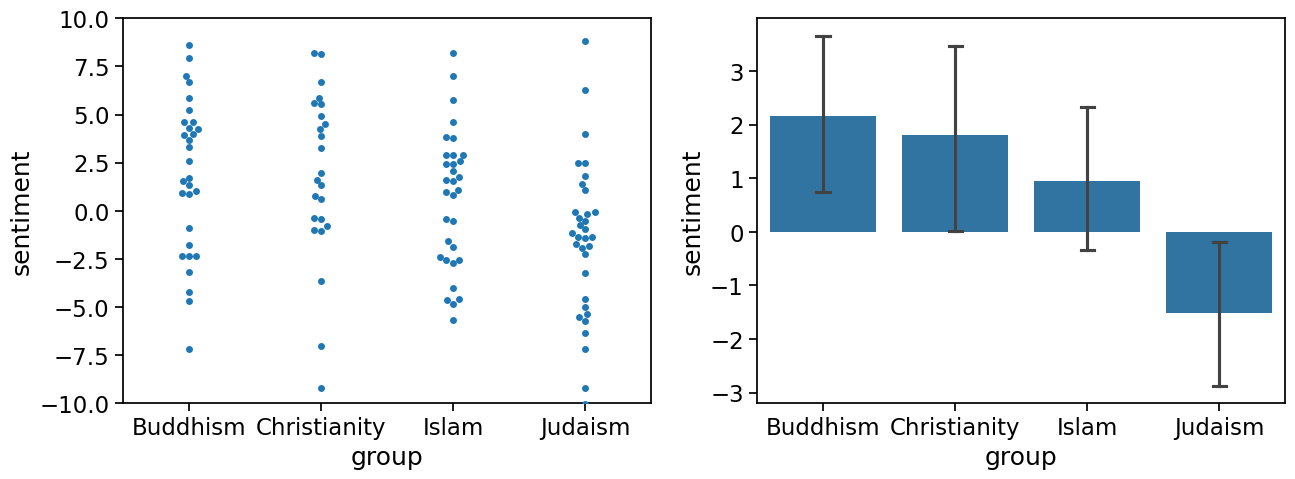

In [ ]:
matplotlib.pyplot.figure(figsize=(15,5))
matplotlib.pyplot.subplot(121)
plot = seaborn.swarmplot(x='group', y='sentiment', data=name_sentiments)
plot.set_ylim([-10, 10])
matplotlib.pyplot.subplot(122)
plot = seaborn.barplot(x='group', y='sentiment', data=name_sentiments, capsize=.1)


**Wilma Edit**:    What does this mean and does it still apply tou our religious bias plot above?:    
We can see that as a bar-plot, too, showing the 95% confidence intervals of the means.

## Step 7: Trying different data

Now that we have the ability to measure prejudicial badness in our word vectors, let's try to improve it. To do so, we'll want to repeat a bunch of things that so far we just ran as individual steps in this Python notebook.

If I were writing good, maintainable code, I wouldn't have been using global variables like `model` and `embeddings`. But writing ad-hoc spaghetti research code let us look at what we were doing at every step and learn from it, so there's something to be said for that. Let's re-use what we can, and at least define a function for redoing some of these steps:

In [ ]:
import scipy.stats as stats

def retrain_model(new_embs, title = ''):
    """
    Repeat the steps above with a new set of word embeddings.
    """
    # use these from outside the function and update them globally
    global model, embeddings, name_sentiments
    embeddings = new_embs
    # get the positive and negative embeddings
    pos_words_common = list(set(pos_words) & set(embeddings.index))
    neg_words_common = list(set(neg_words) & set(embeddings.index))
    pos_vectors = embeddings.loc[pos_words_common]
    neg_vectors = embeddings.loc[neg_words_common]
    vectors = pd.concat([pos_vectors, neg_vectors])
    targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
    labels = list(pos_vectors.index) + list(neg_vectors.index)

    # split the data
    train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
        train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

    # train our model
    model = SGDClassifier(loss='log_loss', random_state=0, max_iter=100)
    model.fit(train_vectors, train_targets)

    # print out a goodness of fit
    accuracy = accuracy_score(model.predict(test_vectors), test_targets)
    print("Accuracy of sentiment: {:.2%}".format(accuracy))

    # get the name table of different people's names and save embeddings
    name_sentiments = name_sentiment_table()

    stats.f_oneway(
        name_sentiments['sentiment'][name_sentiments['group'] == 'Christianity'],
        name_sentiments['sentiment'][name_sentiments['group'] == 'Judaism'],
        name_sentiments['sentiment'][name_sentiments['group'] == 'Buddhism'],
        name_sentiments['sentiment'][name_sentiments['group'] == 'Islam'],
    )

    name_sentiments = name_sentiment_table()

    fstat,pval = stats.f_oneway(
        name_sentiments['sentiment'][name_sentiments['group'] == 'Christianity'],
        name_sentiments['sentiment'][name_sentiments['group'] == 'Judaism'],
        name_sentiments['sentiment'][name_sentiments['group'] == 'Buddhism'],
        name_sentiments['sentiment'][name_sentiments['group'] == 'Islam'],
    )
    print('F-statistic:',fstat,' With P-value:', pval)

    # Show the results on a swarm plot, with a consistent Y-axis
    matplotlib.pyplot.figure(figsize=(15,5))
    matplotlib.pyplot.subplot(121)
    plot = seaborn.swarmplot(x='group', y='sentiment', data=name_sentiments)
    plot.set_ylim([-10, 10])
    matplotlib.pyplot.subplot(122)
    plot = seaborn.barplot(x='group', y='sentiment', data=name_sentiments, capsize=.1)
    matplotlib.pyplot.suptitle(title, fontsize=16)

### Trying word2vec

You may think this is a problem that only GloVe has. If the system weren't trained on all of the Common Crawl (which contains lots of unsavory sites and like 20 copies of Urban Dictionary), maybe it wouldn't have gone bad. **What about good old word2vec, trained on Google News?**

The most authoritative source for the word2vec data seems to be [this file on Google Drive](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing). Download it and save it as `data/word2vec-googlenews-300.bin.gz`.

In [ ]:
# pass over this, archived code from Robyn Speer
# We ar skipping over this on the Python ML Class with Dr. Larson
if False:
    # Use a ConceptNet function to load word2vec into a Pandas frame from its binary format
    from conceptnet5.vectors.formats import load_word2vec_bin
    w2v = load_word2vec_bin('large_data/word2vec-googlenews-300.bin.gz', nrows=2000000)

    # word2vec is case-sensitive, so case-fold its labels
    w2v.index = [label.casefold() for label in w2v.index]

    # Now we have duplicate labels, so drop the later (lower-frequency) occurrences of the same label
    w2v = w2v.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
    retrain_model(w2v)

**So: word2vec is even worse. With an F-value over 15, it has even larger differences in sentiment between groups. In retrospect, expecting _news_ to be safe from algorithmic bias was rather a lot to hope for.**

### Trying ConceptNet Numberbatch

Now I  (Robyn Speer) can finally get to discussing my own word-embedding project.

ConceptNet, the knowledge graph I work on with word-embedding features built in, has a training step that adjusts the embeddings to identify and remove some sources of algorithmic racism and sexism. This step is based on Bolukbasi et al.'s "[Debiasing Word Embeddings](https://arxiv.org/abs/1607.06520)", and generalized to address multiple forms of prejudice at once. As far as I know, we're the only semantic system that has anything of the sort built in.

From time to time, we export pre-computed vectors from ConceptNet, a release we give the name [ConceptNet Numberbatch](https://github.com/commonsense/conceptnet-numberbatch). The April 2017 release was the first to include this de-biasing step, so let's load its English vectors and retrain our sentiment model with them.

Download [`numberbatch-en-17.04b.txt.gz`](http://conceptnet.s3.amazonaws.com/downloads/2017/numberbatch/numberbatch-en-17.04b.txt.gz), save it in the `data/` directory, and retrain the model:

Accuracy of sentiment: 96.53%
F-statistic: 4.970372349308276  With P-value: 0.002780175870400654


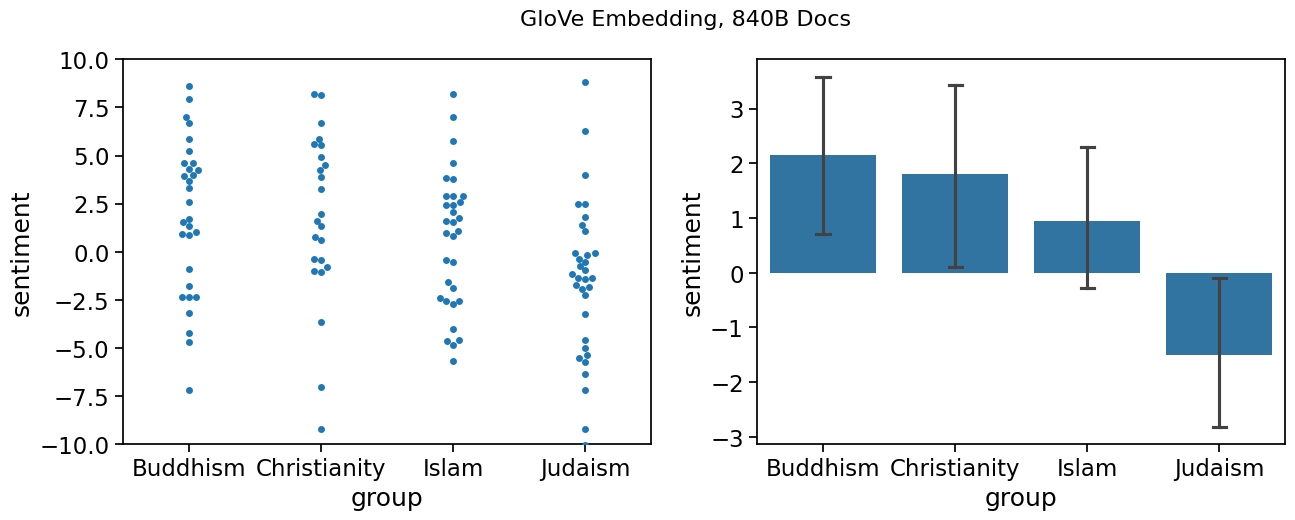

In [ ]:
# repeat eveything for the GLoVe embedding, fair comparison
retrain_model(load_embeddings('/content/drive/MyDrive/CS8321_ML_NN/Lab1/data/glove.840B.300d/glove.840B.300d.txt'), title='GloVe Embedding, 840B Docs')

Accuracy of sentiment: 90.87%
F-statistic: 13.39012428550039  With P-value: 1.707042701584869e-07


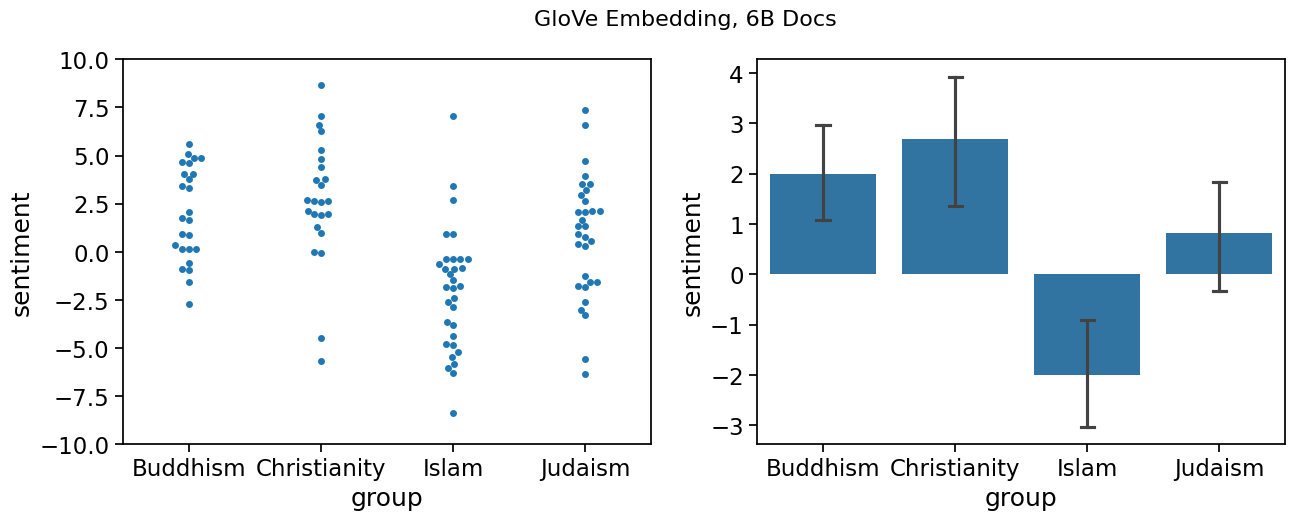

In [ ]:
# repeat eveything for the GLoVe embedding, fair comparison
#retrain_model(load_embeddings('data/glove.6B.300d.txt'), title='GloVe Embedding, 6B Docs')
retrain_model(load_embeddings('/content/drive/MyDrive/CS8321_ML_NN/Lab1/data/glove.6B.300d.txt'), title='GloVe Embedding, 6B Docs')

Accuracy of sentiment: 96.34%
F-statistic: 10.438807182952539  With P-value: 4.420012434901552e-06


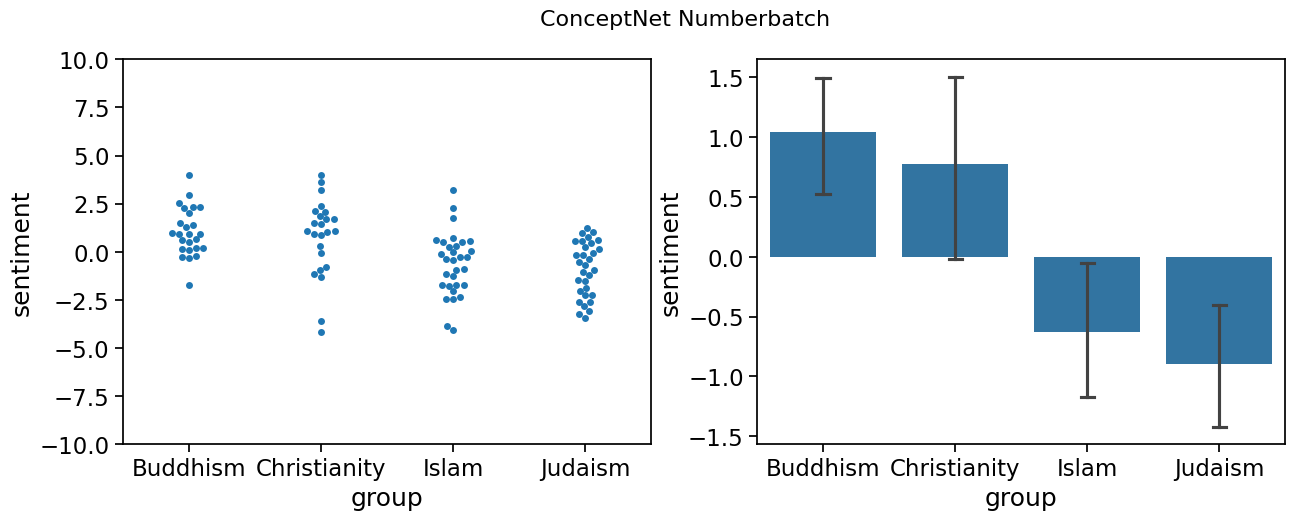

In [ ]:
#retrain_model(load_embeddings('data/numberbatch-en.txt'), title='ConceptNet Numberbatch')
retrain_model(load_embeddings('/content/drive/MyDrive/CS8321_ML_NN/Lab1/data/numberbatch-en-17.04b.txt'), title='ConceptNet Numberbatch')

Okay! So there is a great deal more overlap in the means and the sentiments are more closely tied together, but should we reject the NULL hypothesis that the distributions are the same with p<0.05? Statistically, its okay, but visually, come on! These are still different! So have we entirely fixed the problem by switching to ConceptNet Numberbatch? Can we stop worrying about algorithmic racism? **No.**

Have we made the problem smaller? **Definitely.**

The ranges of sentiments overlap a lot more than they did in the word vectors that came directly from GloVe or word2vec. The F-value is less than a third of what it was for GloVe, and a quarter of what it was for word2vec. And in general, we see much smaller differences in sentiment that come from comparing different given names, which is what we'd hope for, because names really shouldn't matter to the task of sentiment analysis.

But there is still a small correlation. Maybe I could have picked some data or training parameters that made the problem look completely solved. **That would have been a bad move, because the problem _isn't_ completely solved.  There are more causes of algorithmic racism than the ones we have identified and compensated for in ConceptNet.** But this is a good start.

### There is no trade-off

Note that the accuracy of sentiment prediction went *up* when we switched to ConceptNet Numberbatch.

Some people expect that fighting algorithmic racism is going to come with some sort of trade-off. There's no trade-off here. You can have data that's better and less racist. You can have data that's better *because* it's less racist. **There was never anything "accurate" about the overt racism that word2vec and GloVe learned.**

## Other approaches

This is of course only one way to do sentiment analysis. All the steps we used are common, but you probably object that you wouldn't do it that way. **But if you have your own process, I urge you to see if your process is encoding prejudices and biases in the model it learns.**

**Ideas for Lab One from Robyn Spear:**
- Instead of or in addition to changing your source of word vectors, you could try to fix this problem in the output directly. It may help, for example, to build a stronger model of whether sentiment should be assigned to words at all, designed to specifically exclude names and groups of people.
- You could abandon the idea of inferring sentiment for words, and only count the sentiment of words that appear exactly in the list. This is perhaps the most common form of sentiment analysis -- the kind that includes no machine learning at all. Its results will be no more biased than whoever made the list. But the lack of machine learning means that this approach has low recall, and the only way to adapt it to your data set is to edit the list manually.
- As a hybrid approach, you could produce a large number of inferred sentiments for words, and have a human annotator patiently look through them, making a list of exceptions whose sentiment should be set to 0. The downside of this is that it's extra work; the upside is that you take the time to actually see what your data is doing. And that's something that I think should happen more often in machine learning anyway.

**Other Ideas**:
- Try to quantize racial and gender bias in a different way with two different embeddings, and then come up with (and test) a mitigation strategy. For example, look at sentiment in an RNN or X-former model. Could you apply attention differently such that certain words are always weighted with small value (or even zero) for the task of sentiment analysis?
- Another method might ... What?

#### Wilma Edit:
##### Create an RNN-LSTM for Sentiment Analysis

REF CITE:  https://towardsdatascience.com/a-beginners-guide-on-sentiment-analysis-with-rnn-9e100627c02e

Design an RNN model for sentiment analysis
Build our model architecture in the code cell below. We have imported some layers from Keras that you might need but feel free to use any other layers / transformations you like.

Remember that our input is a sequence of words (technically, integer word IDs) of maximum length = max_words, and our output is a binary sentiment label (0 or 1).

### Pad sequences

In order to feed this data into our RNN, all input documents must have the same length. We will limit the maximum review length to max_words by truncating longer reviews and padding shorter reviews with a null value (0). We can accomplish this using the pad_sequences() function in Keras. For now, set max_words to 500.

In [ ]:
#train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
#    train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

In [12]:
from keras.preprocessing import sequence

max_words = 300
#X_train = sequence.pad_sequences(train_labels, maxlen=max_words)
#X_test = sequence.pad_sequences(test_labels, maxlen=max_words)

In [13]:
vocabulary_size = len(pos_words_common) + len(neg_words_common)

#pos_vectors = embeddings.loc[pos_words_common]
#print(vectors)

#if embedding_value is not None:
    #embedding_matrix[i] = embedding_value
#print(embedding_matrix)


In [ ]:
#print(labels)

In [ ]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

print(vocabulary_size)
#example: model.add(Embedding(vocab_size,300,weights = [embedding_matrix],input_length=300,trainable = False))


embedding_size=300
model=Sequential()
#model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(Embedding(vocabulary_size, embedding_size, weights = [embedding_matrix], input_length=max_words,trainable=False))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

6616
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          1984800   
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2145301 (8.18 MB)
Trainable params: 160501 (626.96 KB)
Non-trainable params: 1984800 (7.57 MB)
_________________________________________________________________
None


To summarize, our model is a simple RNN model with 1 embedding, 1 LSTM and 1 dense layers. 213,301 parameters in total need to be trained.

### Train and evaluate our model

We first need to compile our model by specifying the loss function and optimizer we want to use while training, as well as any evaluation metrics we'd like to measure. Specify the approprate parameters, including at least one metric 'accuracy'.

In [14]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

NameError: name 'model' is not defined

Once compiled, we can kick off the training process. There are two important training parameters that we have to specify - batch size and number of training epochs, which together with our model architecture determine the total training time.

Training may take a while, so grab a cup of coffee, or better, go for a run!

In [ ]:

batch_size = 64
num_epochs = 3

#X_valid, y_valid = train_vectors[:batch_size], train_targets[:batch_size]
#X_train2, y_train2 = train_vectors[batch_size:], train_targets[batch_size:]

#model.fit(X_train2, y_train2, validation_data=(X_valid, y_valid), batch_size=batch_size, epochs=num_epochs)

#X_valid = train_vectors[:batch_size]
#X_train2 = train_vectors[batch_size:]


#model.fit(X_train2,y_train2, batch_size=batch_size, epochs=num_epochs)
model.fit(train_vectors,train_targets, epochs=num_epochs)



Epoch 1/3


InvalidArgumentError: Graph execution error:

Detected at node sequential_1/embedding_1/embedding_lookup defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-70-443d800b3b93>", line 14, in <cell line: 14>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py", line 272, in call

indices[20,105] = -1 is not in [0, 6616)
	 [[{{node sequential_1/embedding_1/embedding_lookup}}]] [Op:__inference_train_function_3756]


scores[1] will correspond to accuracy if we pass metrics=['accuracy']

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.86964
